# Differential abundance analysis

In [41]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

warnings.filterwarnings(action="ignore")

import data_support as sup
import matplotlib.pyplot as plt
import numpy as np
import protvi
import protvi.plots as pl
import scanpy as sc
import scvi
import seaborn as sns

scvi.settings.seed = 0

Seed set to 0


Let"s load the data.

In [2]:
adata = sc.read_h5ad("../../data/processed/manns_inhouse.h5ad")

Let's now train the model.

In [3]:
adata.X = adata.layers["main"].copy()
adata.X[np.isnan(adata.X)] = 0

In [4]:
protvi.model.PROTVI.setup_anndata(adata, batch_key="Plate", continuous_covariate_keys=["log Qalb"])

model = protvi.model.PROTVI(adata, log_variational=False, decoder_type="selection", n_hidden=32)
# model.view_anndata_setup()

Let's train the model.

In [5]:
model.train(
    max_epochs=1500,
    plan_kwargs={"mechanism_weight": 1, "min_kl_weight": 0, "max_kl_weight": 1},
    check_val_every_n_epoch=10,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1500/1500: 100%|██████████| 1500/1500 [13:16<00:00,  1.74it/s, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.48e+3]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1500/1500: 100%|██████████| 1500/1500 [13:16<00:00,  1.88it/s, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.48e+3]


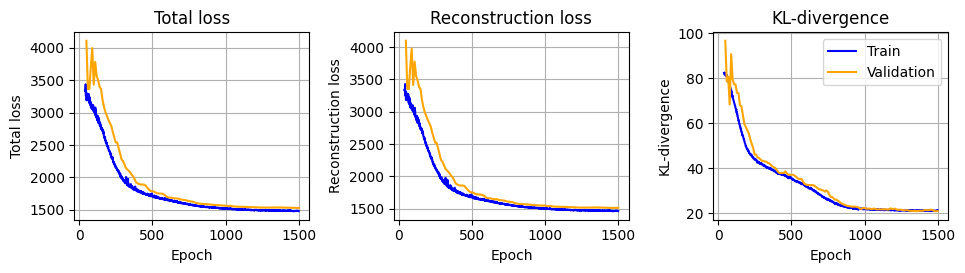

In [6]:
pl.plot_loss(model.history, epoch_start=40, validation_smooth_window=10)

In [7]:
model.save("protvi_checkpoint")

### Evaluation on training set (MAIN)

In [17]:
model = protvi.model.PROTVI.load("protvi_checkpoint", adata)

INFO     File protvi_checkpoint/model.pt already downloaded                                                        


In [9]:
x_est, p_est = model.impute(n_samples=100)

x_main = adata.layers["main"]
x_pilot = adata.layers["pilot"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_main)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_main)] = np.nan

Let's look at the predicted detection probability for each protein, and compare it to the observed missingness.

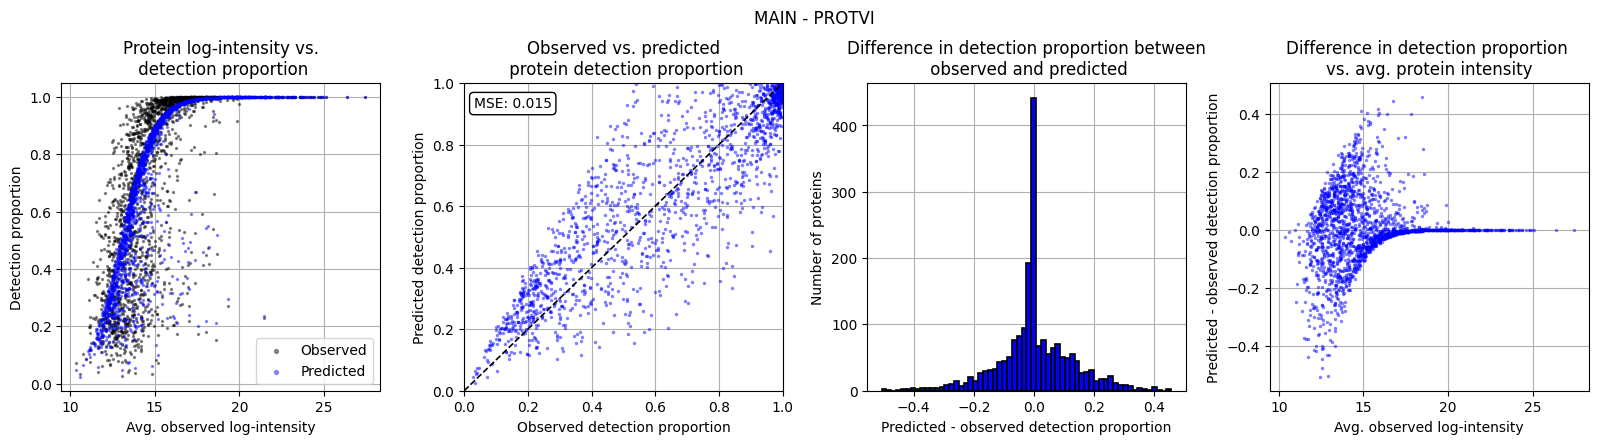

In [10]:
pl.plot_protein_detection_proportion_panel(x_main, p_est, title="MAIN - PROTVI")

Let's now compare the protein intensities predicted by the model and the intensities in MAIN.

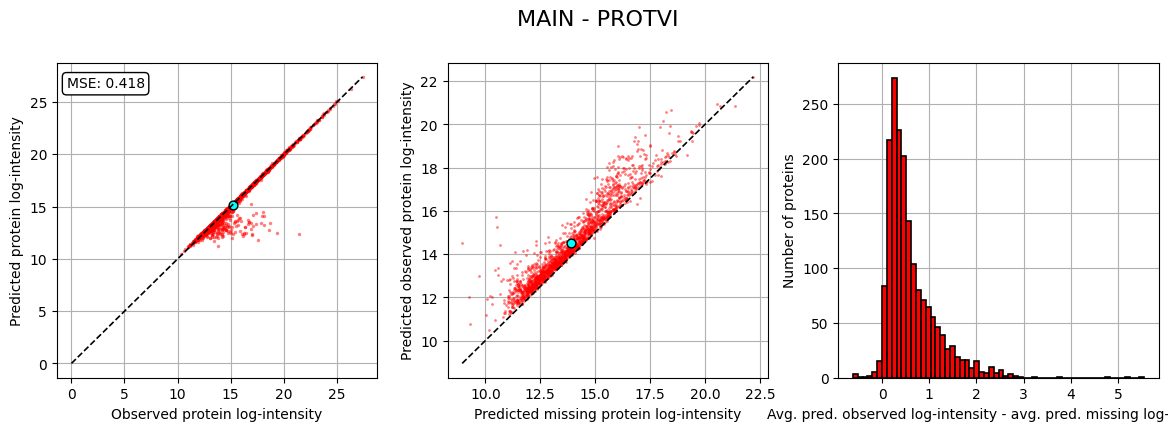

In [11]:
pl.plot_protein_intensity_panel(x_main, x_est, title="MAIN - PROTVI")

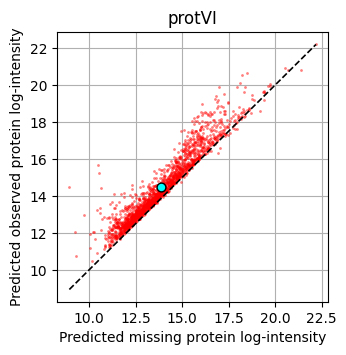

In [12]:
pl.scatter_compare_obs_mis_protein_intensity(x_main, x_est, title="protVI")

In [18]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

In [19]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

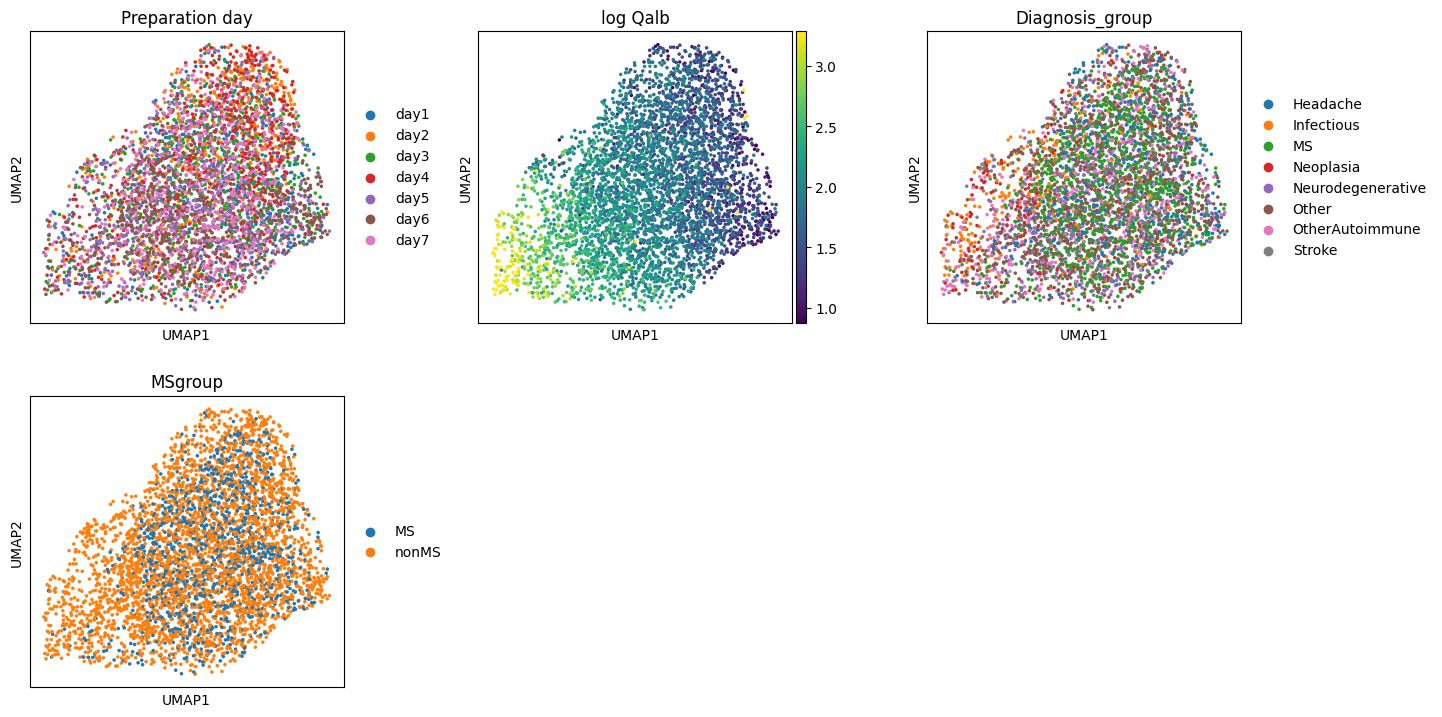

In [20]:
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(
        adata,
        color=["Preparation day", "log Qalb", "Diagnosis_group", "MSgroup"],
        vmin="p01",
        vmax="p99",
        ncols=3,
        wspace=0.3,
    )

Let's do DE.

In [22]:
cell_type_1 = "MS"
cell_idx1 = adata.obs["MSgroup"] == cell_type_1
print(sum(cell_idx1), "cells of type", cell_type_1)

cell_type_2 = "nonMS"
cell_idx2 = adata.obs["MSgroup"] == cell_type_2
print(sum(cell_idx2), "cells of type", cell_type_2)

1209 cells of type MS
3357 cells of type nonMS


In [55]:
model.get_normalized_abundance(n_samples=2, return_numpy=True, return_mean=False).shape

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


PROTVI Model with the following params: 
n_hidden: 32, n_latent: 10, n_layers: 1, dropout_rate: 0.1
Training status: Trained

(2, 4566, 2018)

In [70]:
de_change = model.differential_abundance(idx1=cell_idx1, idx2=cell_idx2, batch_correction=True, mode="change")

DE...: 100%|██████████| 1/1 [00:14<00:00, 14.57s/it]


In [71]:
de_change = de_change.join(adata.var, how="inner")

In [77]:
de_change["is_de_fdr_0.05"].sum()

0

<Axes: xlabel='lfc_mean', ylabel='proba_de'>

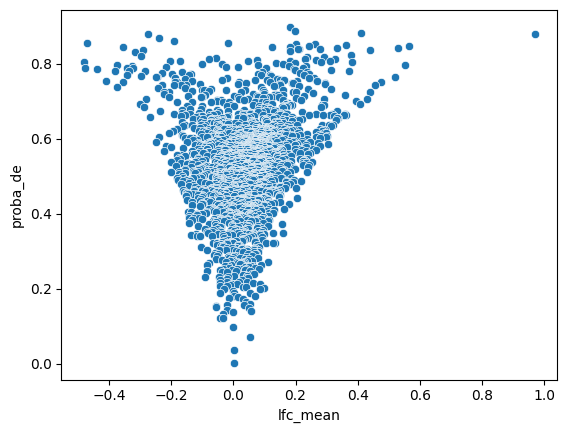

In [78]:
sns.scatterplot(de_change, x="lfc_mean", y="proba_de")